# <center>Physics-informed neural network</center>

### Problema inverso

Conociendo puntos de $u$, se buscará $\gamma$ en la siguiente EDP elíptica:

\begin{align*}
&\nabla\cdot\left(\gamma(x,y) \nabla u(x,y)\right) = f(x,y), & (x,y)\in[-\pi,\pi]\times[-\pi,\pi]\\
&f(x,y) = -5(\sin(xy)+2)\cos(x+2y) - (2x+y)\sin(x+2y)\cos(xy)&
\end{align*}

donde se forzó la solución analítica $u(x,t) = 2\cos(x+2y)$ para $\gamma(x,y) = 1+ \frac{1}{2} \sin(xy)$.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Red neuronal

In [2]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(2 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 2)

        # Inicialización de Xavier para tanh:
        def init_weights(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
        self.apply(init_weights)
    
    def forward(self, x, t):
        input = torch.stack([x, t], axis=1)
        
        for layer in self.inner_layers:
            input = nn.Tanh()(layer(input))
        input = self.last_layer(input)
        
        return input[:, 0], input[:, 1]

In [3]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

#### PDE

In [4]:
import torch
from matplotlib import pyplot as plt

sin, cos = torch.sin, torch.cos
x_domain, y_domain = [-torch.pi, torch.pi], [-torch.pi, torch.pi]

def pde(x, y, net):
    u, gamma = net(x, y)
    u_x = derivative(u, x)
    u_y = derivative(u, y)
    u_xx = derivative(u_x, x)
    u_yy = derivative(u_y, y)
    gamma_x = derivative(gamma, x)
    gamma_y = derivative(gamma, y)
    f = -5 * (sin(x*y)+2) * cos(x+2*y) - (2*x+y) * sin(x+2*y) * cos(x*y)
    return gamma * (u_xx + u_yy) + gamma_x * u_x + gamma_y * u_y - f

def analytical_u(x, y):
    return 2 * cos(x + 2*y)

def analytical_gamma(x, y):
    return 1 + 1/2 * sin(x*y)

#### Entrenamiento

In [5]:
net = NeuralNetwork(n_layers=5, wide=200)
optimizer = torch.optim.LBFGS(net.parameters(), line_search_fn='strong_wolfe')

In [6]:
samples_known, samples_collocation = 1000, 1000
epochs = 50
known_weight = 0.9

# Creación de data (fija):
x_collocation = torch.empty(samples_collocation).uniform_(*x_domain).requires_grad_()
y_collocation = torch.empty(samples_collocation).uniform_(*y_domain).requires_grad_()
target_collocation = torch.zeros(samples_collocation)

x_known = torch.empty(samples_known).uniform_(*x_domain)
y_known = torch.empty(samples_known).uniform_(*y_domain)
target_known = analytical_u(x_known, y_known)

# Entrenamiento:
for epoch in range(1, epochs + 1):

    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        
        # Data conocida:
        u_known, gamma_known = net(x_known, y_known)
        loss_known = nn.MSELoss()(u_known, target_known)
        
        # Colocación:
        pde_collocation = pde(x_collocation, y_collocation, net)
        loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)
        
        # Optimización:
        loss = known_weight * loss_known + (1 - known_weight) * loss_collocation
        if loss.requires_grad:
          loss.backward()

        return loss

    optimizer.step(closure)

    if epoch % 10 == 0:
      print(f'Epoch {epoch} | loss: {closure():.4f}')

Epoch 10 | loss: 0.0069
Epoch 20 | loss: 0.0013
Epoch 30 | loss: 0.0005
Epoch 40 | loss: 0.0003
Epoch 50 | loss: 0.0001


#### Simulación y comparación con la solución real

Métricas para u:
- Error uniforme: 0.0845
- Error cuadrático medio: 0.0001


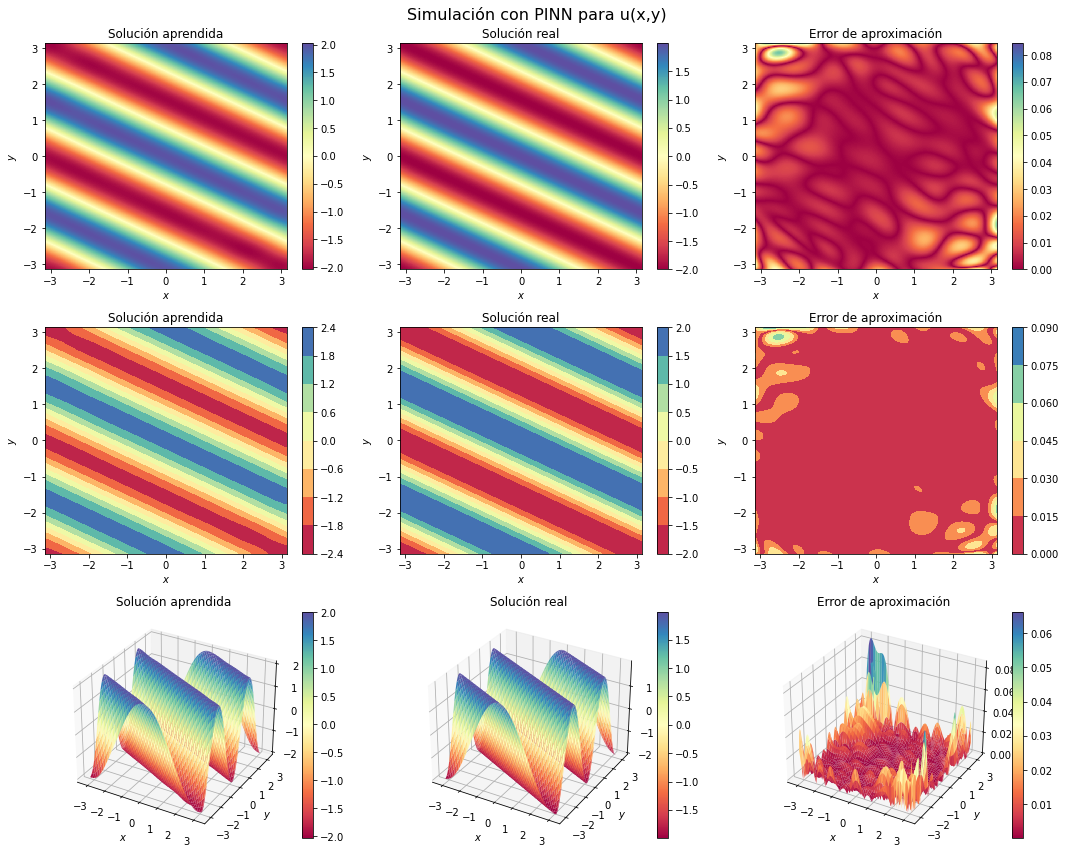

Métricas para gamma:
- Error uniforme: 0.6852
- Error cuadrático medio: 0.0026


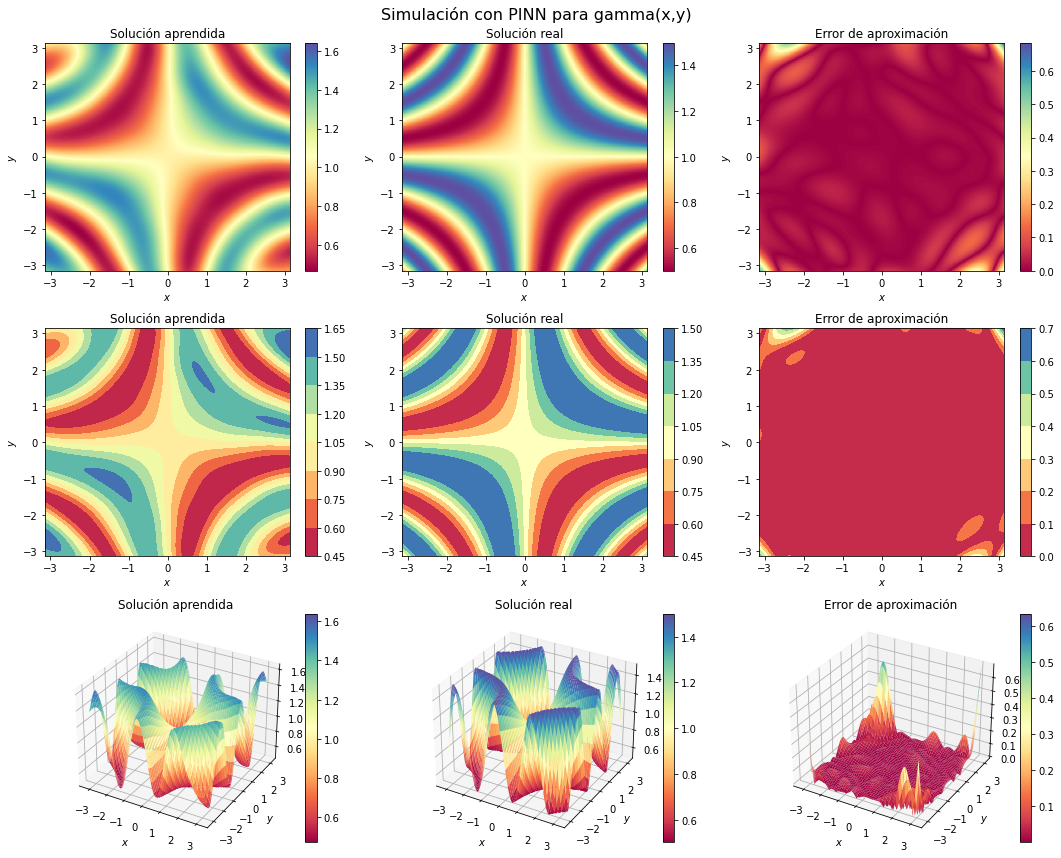

In [7]:
# Puntos del dominio:
x = torch.arange(*x_domain, 1e-2)
y = torch.arange(*y_domain, 1e-2)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
input = grid_x.flatten(), grid_y.flatten()

net.eval()
outputs = net(*input)

for index, eq_name in enumerate(('u', 'gamma')):
    
    # Campos a graficar:
    pred = outputs[index].detach()
    real = analytical_u(*input) if eq_name == 'u' else analytical_gamma(*input)
    error = torch.abs(real - pred)

    print(f'Métricas para {eq_name}:')
    print(f'- Error uniforme: {torch.max(error).item():.4f}')
    print(f'- Error cuadrático medio: {torch.mean(error**2).item():.4f}')
    
    # Gráficos:
    fig = plt.figure(figsize=(15, 12))
    fig.suptitle(f'Simulación con PINN para {eq_name}(x,y)', fontsize=16)
    plotters = 'pcolormesh', 'contourf', 'plot_surface'
    
    values = {'Solución aprendida': pred,
              'Solución real': real,
              'Error de aproximación': error}

    for i, plotter in enumerate(plotters):
        for j, (key, value) in enumerate(values.items()):
            projection = '3d' if plotter == 'plot_surface' else None
            ax = fig.add_subplot(3, 3, 3*i+j+1, projection=projection)
            simulation = getattr(ax, plotter)(grid_x, grid_y, value.reshape_as(grid_x), cmap='Spectral')
            plt.colorbar(simulation)
            ax.set_xlabel('$x$'); ax.set_ylabel('$y$')
            ax.set_title(key)
    plt.tight_layout()
    plt.show()